In [26]:
import pandas as pd 
import numpy as np
from utils import *
import time
from scipy.stats import pearsonr, spearmanr
import matplotlib.pyplot as plt
%matplotlib inline
# import tensorflow as tf
# from keras.backend.tensorflow_backend import set_session
# config = tf.ConfigProto()
# config.gpu_options.allow_growth = True
# set_session(tf.Session(config=config))

In [2]:
df = pd.read_csv("./data/CONTEST_DATA_IN_SAMPLE_1.csv",header=None)
df2 = pd.read_csv("./data/CONTEST_DATA_IN_SAMPLE_2.csv",header=None)
df = pd.concat([df,df2])
df.columns = ['time','stkcd','open','high','low','close','volume']

In [88]:
len(pd.read_csv("./data/CONTEST_DATA_IN_SAMPLE_1.csv",header=None))

386100

In [86]:
df2[0]

0           0
1           0
2           0
3           0
4           0
         ... 
280795    799
280796    799
280797    799
280798    799
280799    799
Name: 0, Length: 280800, dtype: int64

In [3]:
close_df = pd.DataFrame()
high_df = pd.DataFrame()
low_df = pd.DataFrame()
volume_df = pd.DataFrame()
for sub_df in df.groupby('stkcd'):
    close_df[sub_df[0]] = sub_df[1].reset_index().close
    high_df[sub_df[0]] = sub_df[1].reset_index().high
    low_df[sub_df[0]] = sub_df[1].reset_index().low
    volume_df[sub_df[0]] = sub_df[1].reset_index().volume
highs = high_df.values
lows = low_df.values
closes = close_df.values
volumes = volume_df.values

In [17]:
horizon = 1
rts = close_df.pct_change(horizon).shift(-horizon-1).fillna(0).values # returns

In [11]:
a = np.empty((0,351))

In [37]:
start = time.time()
# a = np.vstack([a,mfi])
mfis.append(mfi)
end = time.time()
print((end-start)*10000000)
# a.shape

0.0


In [36]:
len(mfis)

913

In [38]:
closes.shape

(1900, 351)

In [5]:
avgs = np.empty((0,closes.shape[1]))
moms = np.empty((0,closes.shape[1]))
vols = np.empty((0,closes.shape[1]))
max52s = np.empty((0,closes.shape[1]))
min52s = np.empty((0,closes.shape[1]))
ccis = np.empty((0,closes.shape[1]))
Ks = np.empty((0,closes.shape[1]))
Ds = np.empty((0,closes.shape[1]))
Js = np.empty((0,closes.shape[1]))
rsis = np.empty((0,closes.shape[1]))
trixs = np.empty((0,closes.shape[1]))
willrs = np.empty((0,closes.shape[1]))
macds = np.empty((0,closes.shape[1]))
natrs = np.empty((0,closes.shape[1]))
mfis = np.empty((0,closes.shape[1]))
start = time.time()
for i in range(1,len(closes)+1):
    c = closes[:i]
    h = highs[:i]
    l = lows[:i]
    v = volumes[:i]
    avg=get_avg(c,3)
    mom=get_mom(c,5)
    vol=get_vol(c,5)
    max52=get_52weekhigh(c)
    min52=get_52weeklow(c)
    cci = get_cci(h,l,c)
    K,D,J = get_kdj(h,l,c)
    rsi = get_rsi(c)
    trix = get_trix(c)
    willr = get_willr(h,l,c)
    macd = get_macd(c)
    natr = get_natr(h,l,c)
    mfi = get_mfi(c,h,l,v)

    avgs=np.vstack([avgs,avg])
    moms=np.vstack([moms,mom])
    vols=np.vstack([vols,vol])
    max52s=np.vstack([max52s,max52])
    min52s=np.vstack([min52s,min52])
    ccis=np.vstack([ccis,cci])
    Ks=np.vstack([Ks,K])
    Ds=np.vstack([Ds,D])
    Js=np.vstack([Js,J])
    rsis=np.vstack([rsis,rsi])
    trixs=np.vstack([trixs,trix])
    willrs=np.vstack([willrs,willr])
    macds=np.vstack([macds,macd])
    natrs=np.vstack([natrs,natr])
    mfis=np.vstack([mfis,mfi])
    if i%100 == 0:
        print(i)
endtime = time.time()
# print((start-endtime)*1000 / 1900)

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900


In [7]:
a = mfis[100]

In [64]:
def get_weights(factors,top_n=10,tail_n=10,reverse=False):
    weights = np.empty((factors.shape))
    for i,daily_factor in enumerate(factors):
        daily_factor = pd.Series(daily_factor)
        head = daily_factor.nlargest(top_n).index.tolist()
        tail = daily_factor.nsmallest(tail_n).index.tolist()
        weight = np.zeros(factors.shape[1])
        weight[head] = 1 / len(head)
        weight[tail] = -1 / len(tail)
        if reverse:
            weight = -1 * weight
        weights[i] = weight
    return weights

In [ ]:
mom_w = get_weight(moms)

In [92]:
mom_w = get_weight(moms)
mom_weight = pd.DataFrame(mom_w).stack().reset_index()
mom_weight.columns=['date','asset','weight']
mom_weight['asset'] += 1000
mom_weight.to_csv('mom_weight.csv')

In [142]:
def get_performance(factors,returns,top_n=10,tail_n=10,reverse=False,show=False):
    profits = []
    for i,x in enumerate(zip(factors,returns)):
        daily_factor,daily_return = x[0],x[1]
        daily_factor = pd.Series(daily_factor)
        head = daily_factor.nlargest(top_n).index.tolist()
        tail = daily_factor.nsmallest(tail_n).index.tolist()
        weight = np.zeros(returns.shape[1])
        profit = daily_return[head].mean() - daily_return[tail].mean()
        if reverse:
            profit = -profit
        profits.append(profit)
    sharpe = np.sqrt(250) * np.nanmean(profits) / np.nanstd(profits)
    cum_profit = pd.Series(np.asarray(profits)+1).cumprod()
    totalprofit = cum_profit.iloc[-1] - 1
    annual = totalprofit * 252 / returns.shape[0]
    maxdd = (cum_profit-cum_profit.expanding().max()).min()
    if show:
        plt.show()
    return profits,{
        'Total Return':totalprofit,
        'Annual Return':annual,
        'Sharpe Ratio':sharpe,
        'MaxDD':maxdd}

In [45]:
prof, all_results['mom'] = get_performance(moms,rts,reverse=True)

In [53]:
cum_profit = (pd.Series(prof)).cumsum()
maxdd = (cum_profit-cum_profit.expanding().max()).min()

In [43]:
pd.DataFrame(all_results).T

,Total Return,Annual Return,Sharpe Ratio,MaxDD
avg,50.904201,6.751505,2.057582,-3.382555
mom,217.680733,28.871339,2.205558,-53.737019
vol,11.307171,1.499688,1.177843,-3.307538
max52,1.397475,0.185349,0.663979,-0.533917
min52,1.397475,0.185349,0.663979,-0.533917
cci,1.397475,0.185349,0.663979,-0.533917
K,23.080138,3.061155,2.091158,-2.024070
D,23.398887,3.103431,2.108682,-2.458000
J,9.348372,1.239889,1.595170,-1.281415
trix,2.608193,0.345929,0.681773,-4.187431


In [152]:
mean_prof = np.mean([avg_prof,vol_prof,max52_prof,min52_prof,cci_prof,K_prof,D_prof,J_prof,trix_prof,willr_prof,macd_prof,natr_prof,mfi_prof],axis=0)

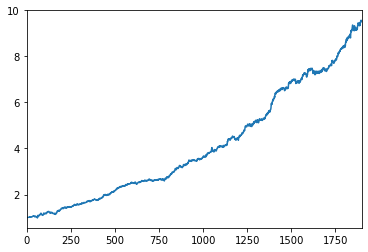

In [153]:
pd.Series(mean_prof+1).cumprod().plot()

[]

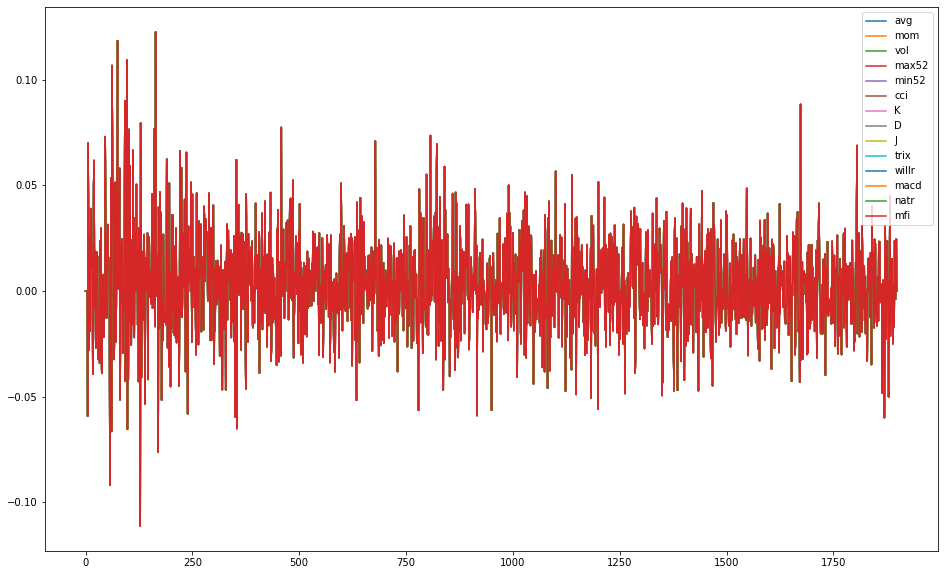

In [143]:
plt.figure(figsize=(16,10))
all_results = {}
avg_prof, all_results['avg'] = get_performance(avgs,rts,reverse=True)
plt.plot(prof,label='avg')
mom_prof, all_results['mom'] = get_performance(moms,rts,reverse=True)
plt.plot(prof,label='mom')
vol_prof, all_results['vol'] = get_performance(vols,rts,reverse=False)
plt.plot(prof,label='vol')
max52_prof, all_results['max52'] = get_performance(mfis,rts,reverse=True)
plt.plot(prof,label='max52')
min52_prof, all_results['min52'] = get_performance(mfis,rts,reverse=True)
plt.plot(prof,label='min52')
cci_prof, all_results['cci'] = get_performance(mfis,rts,reverse=True)
plt.plot(prof,label='cci')
K_prof, all_results['K'] = get_performance(Ks,rts,reverse=True)
plt.plot(prof,label='K')
D_prof, all_results['D'] = get_performance(Ds,rts,reverse=True)
plt.plot(prof,label='D')
J_prof, all_results['J'] = get_performance(Js,rts,reverse=False)
plt.plot(prof,label='J')
trix_prof, all_results['trix'] = get_performance(trixs,rts,reverse=True)
plt.plot(prof,label='trix')
willr_prof, all_results['willr'] = get_performance(willrs,rts,reverse=False)
plt.plot(prof,label='willr')
macd_prof, all_results['macd'] = get_performance(macds,rts,reverse=True)
plt.plot(prof,label='macd')
natr_prof, all_results['natr'] = get_performance(natrs,rts,reverse=False)
plt.plot(prof,label='natr')
mfi_prof, all_results['mfi'] = get_performance(mfis,rts,reverse=True)
plt.plot(prof,label='mfi')
plt.legend()
plt.plot()

In [ ]:
np.mean([])

In [ ]:
# given factors and returns, output test results.
profits = []
for i,x in enumerate(zip(factors,returns)):
    daily_factor,daily_return = x[0],x[1]
    daily_factor = pd.Series(daily_factor)
    head = daily_factor.nlargest(10).index.tolist()
    tail = daily_factor.nsmallest(10).index.tolist()
    profit = daily_return[head].mean() - daily_return[tail].mean()
    profits.append(profit)
pd.Series(np.asarray(profits)+1).cumprod().plot()
plt.show()


out_profits = []
for i,x in enumerate(zip(factors,returns)):
    daily_factor,daily_return = x[0],x[1]
    head = daily_factor.nlargest(10).index.tolist()
    tail = daily_factor.nsmallest(10).index.tolist()
    profit = daily_return[head].mean() - daily_return[tail].mean()
    out_profits.append(profit)
pd.Series(np.asarray(profits)+1).cumprod().plot()
plt.show()

In [72]:
from stock_assess import *

In [93]:
price = pd.read_csv('./data/CONTEST_DATA_IN_SAMPLE_FULL.csv')
price = price[['date','asset','close']]
price.columns = ['date','asset','adjclose']

In [106]:
mom_weight['weight'] *= -1

In [115]:
result=backtest(mom_weight.iloc[-800*351:],price.iloc[-800*351:],bench_code='000905.SH')

In [116]:
result['Performance']

,PtfRet,BenchRet,turnover,AbRet,NetValue,PtfNetValue,BenchNetValue,MaxDrawDown
date,,,,,,,,
1102,0.056744,-0.000635,0.0,0.057379,1.057379,1.056744,0.999365,0.000000
1103,-0.000484,0.006781,1.1,-0.007265,1.049697,1.056233,1.006141,0.007265
1104,-0.000893,-0.005079,1.2,0.004186,1.054091,1.055289,1.001031,0.003109
1105,0.010486,-0.005838,1.0,0.016324,1.071298,1.066355,0.995187,0.000000
1106,0.000227,-0.002963,1.1,0.003189,1.074715,1.066596,0.992239,0.000000
...,...,...,...,...,...,...,...,...
1895,0.023249,0.008353,1.0,0.014897,0.959150,1.783898,1.807099,0.390933
1896,0.019328,-0.000290,0.9,0.019618,0.977967,1.818378,1.806575,0.378984
1897,-0.004430,-0.015221,1.0,0.010791,0.988521,1.810322,1.779076,0.372283


In [117]:
result['Assess']

Annualized Returns                       0.00998128
PtfNetValueRatio                            1.77738
BenchNetValueRatio                          1.76883
NetValueDiff                             0.00855352
Max Drawdown                               0.399873
Sharpe Ratio                               0.190402
Volatility                                 0.318444
Turnover                                    1.01316
WinRate                                    0.511278
Calmar Ratio                              0.0249611
ProfitLoss Ratio                            1.03147
Downside Risk                              0.205813
Sortino Ratio(risk-free rate=0.010)    -9.09394e-05
HighAbRetRate(AbRet>0.030)                 0.066416
LowAbRetRate(AbRet<-0.030)                0.0614035
Time periods                           1102 to 1899
Time length                                     798
dtype: object

In [118]:
result['BearAssess']

Annualized Returns                          3.88219
PtfNetValueRatio                            1.77738
BenchNetValueRatio                          1.76883
NetValueDiff                             0.00855352
Max Drawdown                               0.382889
Sharpe Ratio                                5.72111
Volatility                                 0.285027
Turnover                                    1.00579
WinRate                                    0.636656
Calmar Ratio                                10.1392
ProfitLoss Ratio                            2.56323
Downside Risk                              0.137585
Sortino Ratio(risk-free rate=0.010)         28.1441
HighAbRetRate(AbRet>0.030)                  0.11254
LowAbRetRate(AbRet<-0.030)                0.0160772
Time periods                           1102 to 1899
Time length                                     311
dtype: object

In [119]:
result['BullAssess']

Annualized Returns                        -0.630754
PtfNetValueRatio                            1.73647
BenchNetValueRatio                          1.77182
NetValueDiff                             -0.0353524
Max Drawdown                               0.399873
Sharpe Ratio                               -2.91791
Volatility                                 0.322834
Turnover                                    1.01786
WinRate                                    0.431211
Calmar Ratio                               -1.57738
ProfitLoss Ratio                           0.621878
Downside Risk                              0.222245
Sortino Ratio(risk-free rate=0.010)         -2.8831
HighAbRetRate(AbRet>0.030)                 0.036961
LowAbRetRate(AbRet<-0.030)                0.0903491
Time periods                           1103 to 1898
Time length                                     487
dtype: object

In [104]:
result['Performance']

,PtfRet,BenchRet,turnover,AbRet,NetValue,PtfNetValue,BenchNetValue,MaxDrawDown
date,,,,,,,,
2,-0.041034,0.021642,0.0,-0.062676,0.937324,0.958966,1.021642,0.000000
3,-0.032396,0.004653,0.0,-0.037049,0.902597,0.927899,1.026395,0.037049
4,-0.032776,0.010557,0.0,-0.043333,0.863485,0.897487,1.037232,0.078777
5,0.011100,-0.003815,0.0,0.014915,0.876363,0.907449,1.033275,0.065037
6,-0.040203,0.013813,0.0,-0.054016,0.829026,0.870967,1.047548,0.115540
...,...,...,...,...,...,...,...,...
1895,-0.024249,0.008353,1.0,-0.032602,0.000160,0.000617,3.160391,0.999831
1896,-0.020228,-0.000290,0.9,-0.019939,0.000157,0.000605,3.159474,0.999834
1897,0.003430,-0.015221,1.0,0.018651,0.000160,0.000607,3.111383,0.999831


In [151]:
def get_pnl_by_factors(factors,price,top_n=10,tail_n=10,reverse=True):
    factor_w = get_weights(factors,top_n=top_n,tail_n=tail_n,reverse=reverse)
    factor_weight = pd.DataFrame(factor_w).stack().reset_index()
    factor_weight.columns=['date','asset','weight']
    factor_weight['asset'] += 1000
    result=backtest(factor_weight,price,bench_code='000905.SH')
    return result['Performance']['PtfRet'].values

In [ ]:
factor_pnl = pd.DataFrame()
factor_pnl['avg'] = get_pnl_by_factors(avgs,price)

In [150]:
result['Performance']['PtfRet']

date
2       0.041034
3       0.032396
4       0.032776
5      -0.011100
6       0.040203
          ...   
1895   -0.015945
1896   -0.000665
1897    0.005052
1898   -0.022261
1899   -0.005945
Name: PtfRet, Length: 1898, dtype: float64

In [141]:
factor_w = get_weights(mfis,top_n=10,tail_n=10,reverse=True)
factor_weight = pd.DataFrame(factor_w).stack().reset_index()
factor_weight.columns=['date','asset','weight']
factor_weight['asset'] += 1000
result=backtest(factor_weight,price,bench_code='000905.SH')
print('Overall')
display(result['Assess'])
print("Bull")
display(result['BullAssess'])
print('Bear')
display(result['BearAssess'])

Overall


Annualized Returns                    -0.0832476
PtfNetValueRatio                         1.79099
BenchNetValueRatio                       3.02601
NetValueDiff                            -1.23503
Max Drawdown                            0.769411
Sharpe Ratio                           -0.221712
Volatility                              0.250232
Turnover                                0.395416
WinRate                                 0.489463
Calmar Ratio                           -0.108197
ProfitLoss Ratio                        0.962232
Downside Risk                           0.177947
Sortino Ratio(risk-free rate=0.010)    -0.524018
HighAbRetRate(AbRet>0.030)             0.0279241
LowAbRetRate(AbRet<-0.030)             0.0305585
Time periods                           2 to 1899
Time length                                 1898
dtype: object

Bull


Annualized Returns                     -0.724348
PtfNetValueRatio                          1.8017
BenchNetValueRatio                       3.05168
NetValueDiff                            -1.24998
Max Drawdown                            0.769411
Sharpe Ratio                            -5.36889
Volatility                              0.234212
Turnover                                0.402224
WinRate                                 0.353203
Calmar Ratio                           -0.941432
ProfitLoss Ratio                        0.384625
Downside Risk                           0.191512
Sortino Ratio(risk-free rate=0.010)     -3.83447
HighAbRetRate(AbRet>0.030)             0.0044484
LowAbRetRate(AbRet<-0.030)             0.0480427
Time periods                           2 to 1898
Time length                                 1124
dtype: object

Bear


Annualized Returns                        4.24976
PtfNetValueRatio                          1.69859
BenchNetValueRatio                        2.99195
NetValueDiff                             -1.29336
Max Drawdown                             0.768987
Sharpe Ratio                              7.30465
Volatility                               0.231363
Turnover                                  0.38553
WinRate                                  0.687339
Calmar Ratio                              5.52644
ProfitLoss Ratio                          3.66254
Downside Risk                            0.113525
Sortino Ratio(risk-free rate=0.010)       37.3466
HighAbRetRate(AbRet>0.030)              0.0620155
LowAbRetRate(AbRet<-0.030)             0.00516796
Time periods                            5 to 1899
Time length                                   774
dtype: object